In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def data_process(filename1, filename2):
    vix_df = pd.read_excel(filename1).dropna()
    vix_df = vix_df.rename(columns={'美国:标准普尔500波动率指数(VIX)': 'VIX', '美国:标准普尔500指数': 'SPX500',
                                    '指标名称': 'Date'}).set_index('Date')

    contract_df = pd.read_excel(filename2, index_col=0)

    cols = contract_df.columns
    select_col = [x for x in cols if x[-3:] != 'POS']
    select_col = select_col[:-6]
    df = contract_df[select_col]

    df = df.dropna(how='all')

    df = pd.merge(df, vix_df, left_index=True, right_index=True, how='inner')
    df = df['2007-01-01':]

    months = list(np.unique([m[:-3] for m in df.index.astype(str).tolist()]))

    df_process = pd.DataFrame()
    for m in months[:-1]:
        sub_df = df[m]
        if m < '2020-01':
            if int(m[2:4]) < 9:
                col = [x for x in select_col if m[2:4] in x] + [x for x in select_col if
                                                                ('0' + str(int(m[2:4]) + 1)) in x][:3]
            if int(m[2:4]) < 19:
                col = [x for x in select_col if m[2:4] in x] + [x for x in select_col if str(int(m[2:4]) + 1) in x][:3]
            if int(m[2:4]) == 19:
                col = [x for x in select_col if m[2:4] in x] + select_col[-12:-9]
        else:
            col = select_col[-12:]

        sub = sub_df[col]
        near = int(m[-2:]) + 1
        far = (int(m[-2:]) + 2)
        sub_df['AVG'] = sub.iloc[:, [near, far]].mean(axis=1)

        df_process = df_process.append(sub_df)

    df_process['TRI_S'] = ((df_process['VIX'] < df_process['AVG']).astype(int)).shift(1).rolling(3).sum().fillna(0)
    df_process['LQD_S'] = ((df_process['VIX'] >= df_process['AVG']).astype(int)).shift(1).rolling(3).sum().fillna(0)
    df_process['LONG'] = 100
    df_process['SHORT'] = 0
    df_process['LONG_2'] = 0
    df_process['LONG_3'] = 0
    df_process['SHORT_1'] = 0
    df_process['SHORT_2'] = 0
    return df_process


def heldging_func(df, initial_short_pos=0):
    num_days = len(df)
    dates = df.index.tolist()
    short_roll = 1 / num_days
    long_roll = 1 / num_days
    for i in range(num_days):
        if i == 0:
            df.loc[dates[i], 'SHORT'] = initial_short_pos
            if df.loc[dates[i], 'TRI_S'] == 3:
                df.loc[dates[i], 'SHORT'] = min(100, df.loc[dates[i], 'SHORT'] + df.iloc[i]['LONG'] * 0.2)
        if i != 0:
            # 最后5个交易日不交易
            if df.loc[dates[i], 'TRI_S'] == 3 and (num_days - i) > 5:
                df.loc[dates[i], 'SHORT'] = min(100, df.iloc[i - 1]['SHORT'] + df.iloc[i]['LONG'] * 0.2)
            elif df.iloc[i]['LQD_S'] == 3 and (num_days - i) > 5:
                df.loc[dates[i], 'SHORT'] = max(0, df.iloc[i - 1]['SHORT'] - df.iloc[i]['LONG'] * 0.2)
                # print(df.iloc[i - 1]['SHORT'] - df.iloc[i]['LONG'] * 0.2)
            else:
                df.loc[dates[i], 'SHORT'] = df.loc[dates[i - 1], 'SHORT']

        # 多头展仓
        df.loc[dates[i], 'LONG_3'] = df.loc[dates[i], 'LONG'] * (i + 1) * long_roll
        df.loc[dates[i], 'LONG_2'] = df.loc[dates[i], 'LONG'] - df.loc[dates[i], 'LONG_3']

        # 空头展仓
        if df.loc[dates[i], 'SHORT'] != 0:
            df.loc[dates[i], 'SHORT_2'] = df.loc[dates[i], 'SHORT'] * (i + 1) * short_roll
            df.loc[dates[i], 'SHORT_1'] = df.loc[dates[i], 'SHORT'] - df.loc[dates[i], 'SHORT_2']
    initial_short_pos = df.iloc[-1]['SHORT']
    return df, initial_short_pos

In [ ]:
filename1 = 'DATA/市场波动率指数(VIX).xls'
filename2 = 'DATA/CT_Data.xlsx'
df = data_process(filename1, filename2)

months = list(np.unique([m[:-3] for m in df.index.astype(str).tolist()]))
initial_short_pos = 0
out_df = pd.DataFrame()
for m in tqdm(months):
    sub_df = df[m]
    sub_df, initial_short_pos = heldging_func(sub_df, initial_short_pos)
    out_df = out_df.append(sub_df)
    
out_df.to_excel('output.xlsx')

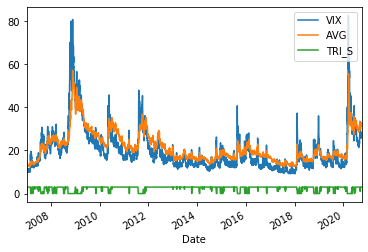

In [6]:
df[['VIX', 'AVG', 'TRI_S']].plot()
plt.legend(loc=1)